In this notebook, we'll learn how to use GANs to do semi-supervised learning.

In supervised learning, we have a training set of inputs $x$ and class labels $y$. We train a model that takes $x$ as input and gives $y$ as output.

In semi-supervised learning, our goal is still to train a model that takes $x$ as input and generates $y$ as output. However, not all of our training examples have a label $y$. We need to develop an algorithm that is able to get better at classification by studying both labeled $(x, y)$ pairs and unlabeled $x$ examples.

To do this for the SVHN dataset, we'll turn the GAN discriminator into an 11 class discriminator. It will recognize the 10 different classes of real SVHN digits, as well as an 11th class of fake images that come from the generator. The discriminator will get to train on real labeled images, real unlabeled images, and fake images. By drawing on three sources of data instead of just one, it will generalize to the test set much better than a traditional classifier trained on only one source of data.

In [1]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf


In [2]:
!mkdir data

A subdirectory or file data already exists.


In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

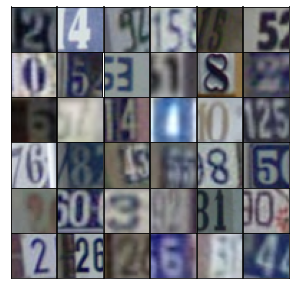

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:1000] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [8]:
from tensorflow.keras import layers

In [9]:
def generator(z_dim, output_dim=3, alpha=0.2, size_mult=128):

    model = tf.keras.Sequential()

    model.add(layers.Dense(4 * 4 * size_mult * 4, input_shape=(z_dim,)))
    model.add(layers.Reshape((4, 4, size_mult * 4)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(size_mult * 2, 5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(size_mult * 2, 5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(output_dim, 5, strides=2, padding='same', activation="tanh"))
    
    return model

In [10]:
def discriminator(input_dim, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):

    model = tf.keras.Sequential()

    model.add(layers.Dropout(drop_rate/2.5, input_shape=input_dim))

    # Input layer is 32x32x3
    model.add(layers.Conv2D(size_mult, 3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha))
    model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2D(size_mult, 3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(size_mult, 3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))
    model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2D(2 * size_mult, 3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(2 * size_mult, 3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(2 * size_mult, 3, strides=1, padding='valid'))
    model.add(layers.LeakyReLU(alpha))

    # used in generator loss calculation
    model.add(layers.GlobalAveragePooling2D())

    # Dense layer with one additional bit to indicate real or fake
    model.add(layers.Dense(num_classes + 1)) # Class logits

    return model

In [11]:
def view_samples(samples, nrows, ncols,  epoch=-1 ,figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    samples = samples[epoch]

    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        # img = np.array((img*127.5 + 127.5),dtype=np.int32)
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [12]:
def stabilize_output(class_logits, fakecls_logits):

    mx_real = tf.reduce_max(class_logits, 1, keepdims=True)
    stable_real_logits = class_logits - mx_real
    gan_logits_real = tf.math.log(tf.reduce_sum(tf.exp(stable_real_logits), 1))\
                                        + tf.squeeze(mx_real) - tf.squeeze(fakecls_logits)
                                        
    return gan_logits_real

In [13]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0003
batch_size = 128
epochs = 30
num_classes = 10

dataset = Dataset(trainset, testset)

In [14]:
generator_model = generator(z_size)
discriminator_model = discriminator((32,32,3))

In [15]:
generator_optimizer = tf.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate, beta_1=0.5)

		Classifier train accuracy 0.0625
		Classifier test accuracy 0.16118623
Epoch 1 completed!
		Classifier train accuracy 0.078125
		Classifier test accuracy 0.24124154
Epoch 2 completed!
		Classifier train accuracy 0.0859375
		Classifier test accuracy 0.35271972
Epoch 3 completed!


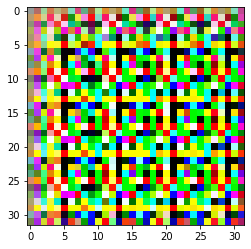

In [16]:
losses = []
samples = []
test_accuracies = []
train_accuracies = []
g_size_mult = 32
d_size_mult = 64


for e in range(epochs):

    for x, y, label_mask in dataset.batches(batch_size):

        noise = tf.random.normal([batch_size, z_size])  # Z input

        num_examples = 0
        num_correct = 0
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator_model(noise, training=True)

            real_output = discriminator_model(x, training=True)
            real_features = discriminator_model.layers[-2].output

            fake_output = discriminator_model(generated_images, training=True)
            fake_features = discriminator_model.layers[-2].output

            # These outputs are 11 class logits, therefore we need to separate them to
            # obtain 2 class probability for the GAN training and 10 class probability for
            # the multiclass classification.
            # output dims are (None, 11) we need to separate it to (None, 10) and (None, 1)
            class_logits_real, fakecls_logits_real = tf.split(real_output, [num_classes, 1], 1)
            class_logits_fake, fakecls_logits_fake = tf.split(fake_output, [num_classes, 1], 1)

            # Stabilizing the outputs
            gan_logits_real = stabilize_output(class_logits_real, fakecls_logits_real)
            gan_logits_fake = stabilize_output(class_logits_fake, fakecls_logits_fake)

            # Discriminator Loss calculation
            # In first to we make the loss change based on the fake/real status
            # Discriminator loss - real values
            d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(\
                                                    tf.ones_like(gan_logits_real),
                                                     gan_logits_real)
            # Discriminator loss - fake values
            d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(\
                                                    tf.ones_like(gan_logits_fake),
                                                    gan_logits_fake)
            # Discriminator loss - class values
            # In here we get the loss based on the actual classification of number.
            y = tf.squeeze(y)
            class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(\
                                                    logits=real_output,
                                                    labels=tf.one_hot(y, num_classes\
                                                            + 1,\
                                                            dtype=tf.float32))
            
            # Since we only consider the values with labels (mask)
            class_cross_entropy = tf.squeeze(class_cross_entropy)
            label_mask = tf.squeeze(tf.convert_to_tensor(label_mask, dtype=tf.float32))
            d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1., tf.reduce_sum(label_mask))
            d_loss = d_loss_class + d_real_loss + d_real_loss


            # Generator Loss Calculation  #TODO Need to fix this part
            # data_moments = tf.reduce_mean(real_features, axis=0)
            # sample_moments = tf.reduce_mean(fake_features, axis=0)
            # g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))
            g_loss = tf.losses.categorical_crossentropy(tf.ones_like(fake_output), fake_output) #TODO This is temporary
            
            
        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator_model.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, generator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
        # print(f"Batch gen-loss={g_loss} disc_loss={d_loss}")
        losses.append((d_loss, g_loss))


        # For Accuracy Measures
        pred_class = tf.cast(tf.argmax(real_output, 1), tf.uint8)
        eq = tf.equal(tf.squeeze(y), pred_class)
        correct = tf.reduce_sum(tf.cast(eq, dtype=tf.float32))
        masked_correct = tf.reduce_sum(label_mask * tf.cast(eq, dtype=tf.float32))

        num_examples = num_examples + batch_size
        num_correct = num_correct + correct
        
    train_accuracy = num_correct / float(num_examples)
    print("Classifier train accuracy", train_accuracy.numpy())
    train_accuracies.append(train_accuracy.numpy())

    num_examples = 0
    num_correct = 0
    for x, y in dataset.batches(batch_size, which_set="test"):
        num_examples += x.shape[0]

        out = discriminator_model(x, training=False)
        
        pred_class = tf.cast(tf.argmax(out, 1), tf.uint8)
        eq = tf.equal(tf.squeeze(y), pred_class)
        correct = tf.reduce_sum(tf.cast(eq, dtype=tf.float32))
        num_correct += correct
    
    test_accuracy = num_correct / float(num_examples)
    print("Classifier test accuracy", test_accuracy.numpy())
    test_accuracies.append(test_accuracy.numpy())

    noise = tf.random.normal([16, 100])
    predictions = generator_model(noise, training=False)
    plt.imshow(np.array((predictions[-1]*127.5 + 127.5), dtype=np.int32))

    samples.append(predictions.numpy())

    losses.append((d_loss, g_loss))

    print(f"\t\tEpoch {e+1} completed!")


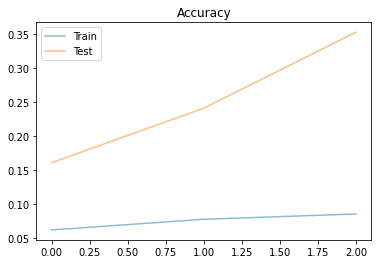

In [17]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

When you run the fully implemented semi-supervised GAN, you should usually find that the test accuracy peaks at 69-71%. It should definitely stay above 68% fairly consistently throughout the last several epochs of training.

This is a little bit better than a [NIPS 2014 paper](https://arxiv.org/pdf/1406.5298.pdf) that got 64% accuracy on 1000-label SVHN with variational methods. However, we still have lost something by not using all the labels. If you re-run with all the labels included, you should obtain over 80% accuracy using this architecture (and other architectures that take longer to run can do much better).

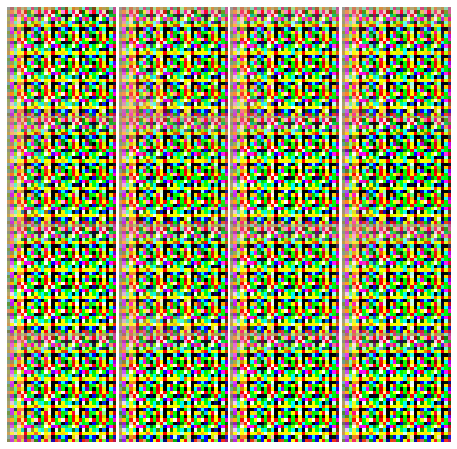

In [18]:
_ = view_samples(samples, 4, 4, figsize=(8,8), epoch=-1)

In [19]:
!mkdir images

In [21]:
for ii in range(len(samples)):
    fig, ax = view_samples(samples, 4, 4, figsize=(8,8), epoch=-1)
    fig.savefig('images/samples_{:03d}.png'.format(ii))
    plt.close()